In [63]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import kagglehub

In [46]:
path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/emotion-detection-fer


In [47]:
train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test")

In [48]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(48, 48),
    batch_size=42,
    color_mode="grayscale")

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


In [49]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(48, 48),
    batch_size=42,
    color_mode="grayscale")

Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [50]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(48, 48),
    batch_size=42,
    color_mode="grayscale")

Found 7178 files belonging to 7 classes.


In [51]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [52]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [53]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
model.compile(optimizer=Adam(0.01), loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,496,903 (17.15 MB)

 Trainable params: 4,492,935 (17.14 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [64]:
checkpoint_cb = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',  # or 'val_loss'
    save_best_only=True,
    save_weights_only=False,  # Set to True if you only want weights
    mode='max',               # Use 'min' for val_loss
    verbose=1)

In [69]:
history = model.fit(x = train_ds, epochs = 45, validation_data = val_ds, callbacks=[checkpoint_cb])

Epoch 1/45
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9071 - loss: 0.2770
Epoch 1: val_accuracy did not improve from 0.60216
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.9071 - loss: 0.2771 - val_accuracy: 0.5813 - val_loss: 1.8314
Epoch 2/45
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9054 - loss: 0.2832
Epoch 2: val_accuracy did not improve from 0.60216
547/547 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9054 - loss: 0.2832 - val_accuracy: 0.5807 - val_loss: 1.7665
Epoch 3/45
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9142 - loss: 0.2561
Epoch 3: val_accuracy did not improve from 0.60216
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.9142 - loss: 0.2561 - val_accuracy: 0.5976 - val_loss: 1.9002
Epoch 4/45
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9165 - loss: 0.2378
Epoch 4: val_accuracy did not improve from 0.60216
547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.9165 - loss: 0.2378 - val_accuracy

547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.9346 - loss: 0.2017 - val_accuracy: 0.6025 - val_loss: 1.9627
Epoch 13/45
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9346 - loss: 0.1929
Epoch 13: val_accuracy did not improve from 0.60251
547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.9346 - loss: 0.1929 - val_accuracy: 0.5893 - val_loss: 1.9737
Epoch 14/45
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9224 - loss: 0.2277
Epoch 14: val_accuracy did not improve from 0.60251
547/547 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9224 - loss: 0.2278 - val_accuracy: 0.5788 - val_loss: 1.8247
Epoch 15/45
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9132 - loss: 0.2539
Epoch 15: val_accuracy did not improve from 0.60251
547/547 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9132 - loss: 0.2539 - val_accuracy: 0.5990 - val_loss: 1.8664
Epoch 16/45
545/547 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9333 - loss: 0.1973
Epoch 16: val_ac

547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.9333 - loss: 0.1973 - val_accuracy: 0.6027 - val_loss: 1.9120
Epoch 17/45
545/547 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9385 - loss: 0.1779
Epoch 17: val_accuracy did not improve from 0.60268
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9385 - loss: 0.1779 - val_accuracy: 0.5861 - val_loss: 2.2133
Epoch 18/45
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9372 - loss: 0.1894
Epoch 18: val_accuracy did not improve from 0.60268
547/547 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9372 - loss: 0.1894 - val_accuracy: 0.6015 - val_loss: 2.1352
Epoch 19/45
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8928 - loss: 0.3231
Epoch 19: val_accuracy did not improve from 0.60268
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.8928 - loss: 0.3230 - val_accuracy: 0.5948 - val_loss: 1.9857
Epoch 20/45
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9378 - loss: 0.1865
Epoch 20: val_ac

547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.9426 - loss: 0.1644 - val_accuracy: 0.6030 - val_loss: 2.1041
Epoch 28/45
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9438 - loss: 0.1716
Epoch 28: val_accuracy did not improve from 0.60303
547/547 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9438 - loss: 0.1716 - val_accuracy: 0.5854 - val_loss: 2.0941
Epoch 29/45
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9455 - loss: 0.1724
Epoch 29: val_accuracy did not improve from 0.60303
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9455 - loss: 0.1724 - val_accuracy: 0.6008 - val_loss: 2.1241
Epoch 30/45
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9410 - loss: 0.1755
Epoch 30: val_accuracy did not improve from 0.60303
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9410 - loss: 0.1755 - val_accuracy: 0.5771 - val_loss: 2.4014
Epoch 31/45
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9521 - loss: 0.1537
Epoch 31: val_ac

547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.9521 - loss: 0.1537 - val_accuracy: 0.6063 - val_loss: 2.0378
Epoch 32/45
545/547 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9538 - loss: 0.1469
Epoch 32: val_accuracy did not improve from 0.60634
547/547 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9538 - loss: 0.1469 - val_accuracy: 0.6034 - val_loss: 2.0383
Epoch 33/45
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9541 - loss: 0.1380
Epoch 33: val_accuracy did not improve from 0.60634
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.9541 - loss: 0.1380 - val_accuracy: 0.5987 - val_loss: 2.1381
Epoch 34/45
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9487 - loss: 0.1476
Epoch 34: val_accuracy did not improve from 0.60634
547/547 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9487 - loss: 0.1476 - val_accuracy: 0.5915 - val_loss: 2.2895
Epoch 35/45
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9520 - loss: 0.1525
Epoch 35: val_ac

In [70]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6118 - loss: 2.1401
Test Accuracy: 0.6123
Test Loss: 2.1913


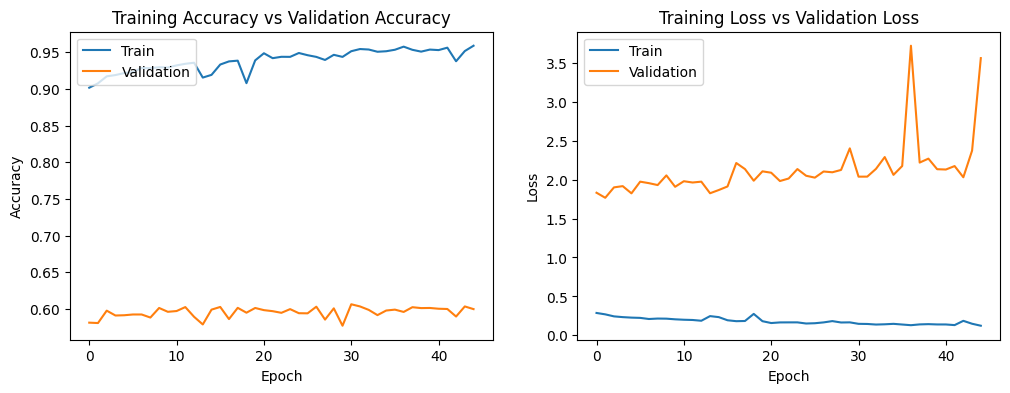

In [71]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()